In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('petr4_treinamento.csv')
df = df.dropna()
train_df = df.iloc[:, 1:3].values

In [3]:
normalizer = MinMaxScaler(feature_range=(0,1))

train_df_norm = normalizer.fit_transform(train_df)

In [4]:
X = []
y = []

for i in range(90, 1242):
    X.append(train_df_norm[i-90:i, 0])
    y.append(train_df_norm[i, 0:2])


X = np.array(X)
y = np.array(y)

In [5]:
X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

In [6]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

In [7]:
class regressor_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=100, batch_first=True)
        self.lstm2 = nn.LSTM(100, 50, batch_first=True)
        self.lstm3 = nn.LSTM(50, 50, dropout=0.3, num_layers=2, batch_first=True)

        self.dropout = nn.Dropout(0.3)

        self.linear = nn.Linear(in_features=50, out_features=2)

    def forward(self, X):
        X = X.unsqueeze(2)

        X, _ = self.lstm1(X)

        X = self.dropout(X)

        X, _ = self.lstm2(X)

        X = self.dropout(X)

        X, _ = self.lstm3(X)

        X = X[:, -1, :]

        X = self.dropout(X)

        X = self.linear(X)

        return X

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
regressor = regressor_LSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters(), lr=0.001)

In [10]:
ES_MIN_DELTA = 1e-10
ES_PATIENCE = 10
RLR_FACTOR = 0.2
RLR_PATIENCE = 5

min_loss = np.inf

In [12]:
for epoch in range(200):
    running_loss = 0.
    running_mae = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = regressor(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(), outputs.detach().cpu().numpy().flatten())

        running_mae += mae

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(loader)}, MAE: {running_mae/len(loader)}')

    running_loss /= len(loader)
    running_mae /= len(loader)

    print(f'Epoch {epoch+1}, Loss: {running_loss}, MAE: {running_mae}')

    if running_loss < min_loss:
        print(f'**Cost function reduced from {min_loss} to {running_loss}**')
        torch.save(regressor.state_dict(), 'model.pth')
        min_loss = running_loss
        es_patience = 0
        rlr_patience = 0

    else:
        print("**Cost does not decrease**")

        if running_loss - min_loss >= ES_MIN_DELTA:
            es_patience += 1
            if es_patience >= ES_PATIENCE:
                print(f'Early stopping at epoch {epoch+1}')
                break

        rlr_patience += 1
        if rlr_patience == RLR_PATIENCE:
            print('-- Criterion of learning rate reduced achieved, reducing LR. --')

            for param_group in optimizer.param_groups:
                param_group['lr'] *= RLR_FACTOR

            rlr_patience = 0


Epoch 1, Loss: 0.009297299716207717, MAE: 0.014993379513422648
Epoch 1, Loss: 0.017283024059401617, MAE: 0.02857376966211531
Epoch 1, Loss: 0.025555373066001467, MAE: 0.04282984965377384
Epoch 1, Loss: 0.032736487686634064, MAE: 0.05592709365818235
Epoch 1, Loss: 0.03746864737735854, MAE: 0.06656210372845332
Epoch 1, Loss: 0.04402885172102186, MAE: 0.07887887706359227
Epoch 1, Loss: 0.04928966280486849, MAE: 0.08985748059219784
Epoch 1, Loss: 0.05523269085420503, MAE: 0.10109362999598186
Epoch 1, Loss: 0.05923245971401533, MAE: 0.11019211345248753
Epoch 1, Loss: 0.06329794683390194, MAE: 0.11936042457818985
Epoch 1, Loss: 0.06632693029112285, MAE: 0.12723303751813042
Epoch 1, Loss: 0.06788581009540293, MAE: 0.13270998497804007
Epoch 1, Loss: 0.0694573861029413, MAE: 0.13831949399577248
Epoch 1, Loss: 0.07048731773263878, MAE: 0.142728457848231
Epoch 1, Loss: 0.07207838394161728, MAE: 0.14790278010898167
Epoch 1, Loss: 0.0732881555126773, MAE: 0.15248770225379202
Epoch 1, Loss: 0.074816

In [23]:
test_df = pd.read_csv('petr4_teste.csv')
all_df = pd.concat((df['Open'], test_df['Open']), axis=0)

entry = all_df[len(all_df) - len(test_df) - 90:].values
entry = entry.reshape(-1, 1)

In [24]:
normalizer = MinMaxScaler(feature_range=(0, 1)).fit(train_df[:, 0:1])
entry = normalizer.transform(entry)

In [25]:
X_test = []

for i in range(90, 112):
    X_test.append(entry[i-90:i, 0])


X_test = np.array(X_test)

In [26]:
X_test = torch.tensor(X_test, device=device, dtype=torch.float32)

In [27]:
regressor.eval()
forecast = regressor(X_test)
regressor = forecast.detach().cpu().numpy()
forecast = normalizer.inverse_transform(regressor)

In [28]:
forecast

array([[16.015757, 16.190687],
       [16.088297, 16.263393],
       [16.15089 , 16.32654 ],
       [16.25153 , 16.42841 ],
       [16.390896, 16.569387],
       [16.541761, 16.721786],
       [16.694538, 16.875973],
       [16.821835, 17.004398],
       [16.89779 , 17.08105 ],
       [16.930614, 17.114342],
       [16.964174, 17.14864 ],
       [17.026203, 17.211834],
       [17.168835, 17.356417],
       [17.428862, 17.6194  ],
       [17.761549, 17.955494],
       [18.070791, 18.267658],
       [18.287052, 18.485891],
       [18.384674, 18.584501],
       [18.47046 , 18.671667],
       [18.638437, 18.842442],
       [18.899555, 19.10756 ],
       [19.201527, 19.413883]], dtype=float32)

In [30]:
forecast.mean(axis=0)

array([17.322094, 17.51097 ], dtype=float32)

In [31]:
test_df['Open'].mean()

17.87454563636364

In [32]:
test_df['High'].mean()

18.148181636363635

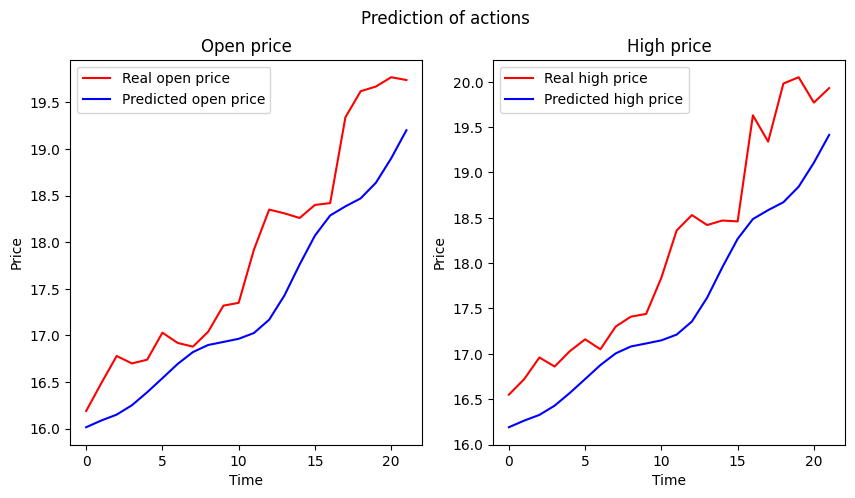

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

fig.suptitle('Prediction of actions')

ax[0].plot(test_df['Open'], color='red', label='Real open price')
ax[0].plot(forecast[:, 0], color='blue', label='Predicted open price')
ax[0].set_title('Open price')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Price')
ax[0].legend()

ax[1].plot(test_df['High'], color='red', label='Real high price')
ax[1].plot(forecast[:, 1], color='blue', label='Predicted high price')
ax[1].set_title('High price')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Price')
ax[1].legend()

plt.show()